In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from src.utils import *
from model_functions import *
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from src.forward_selection import select_features
import matplotlib.pyplot as plt
random.seed(7)

/tmp/ipykernel_3925377/1644916204.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Multitask learning

In [38]:
sweep_output_df = pd.read_csv("intermediate_results/MT_FT_MORT_bootstrap.csv")


In [2]:
import wandb

api = wandb.Api()

sweep = api.sweep("swiergarst/olink-aging/5oy9lds5")
sweep_runs = sweep.runs

In [3]:
c_index, r2_score, beta, bs, lr, wd = [], [], [], [], [], []

for run in sweep_runs:
    # print(run.config)
    # print(run.summary)
    c_index.append(run.summary.concordance_val)
    r2_score.append(run.summary.r2_val)
    beta.append(run.config['beta'])
    bs.append(run.config['bs'])
    lr.append(run.config['lr'])
    wd.append(run.config['wd'])

In [4]:
sweep_df = pd.DataFrame(data = {"concordance_val": c_index, "r2_val": r2_score, 'beta' : beta, 'bs' : bs, 'lr' : lr, 'wd' : wd})

In [5]:
pareto_df = sweep_df.sort_values('concordance_val', ascending = False)
# pareto_df = pareto_df.dropna()
pareto_df = pareto_df.reset_index(drop = True)
idxs_pareto = [0]
for idx, line in pareto_df.iterrows():
    if line['r2_val'] >= pareto_df.iloc[:idx]['r2_val'].max():
        idxs_pareto.append(idx)
pareto_df = pareto_df.iloc[idxs_pareto]


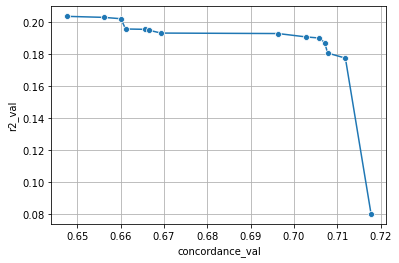

In [6]:
sns.lineplot(pareto_df, x = "concordance_val", y = "r2_val", marker = 'o')
plt.grid()

<Axes: xlabel='concordance_val', ylabel='r2_val'>

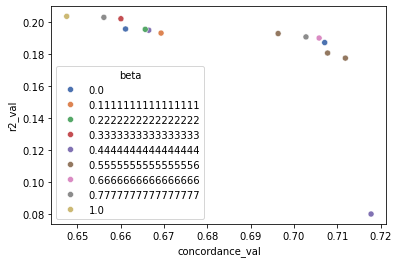

In [7]:
sns.scatterplot(pareto_df, x= "concordance_val", y = "r2_val", hue = 'beta', palette = "deep")

<Axes: xlabel='concordance_val', ylabel='r2_val'>

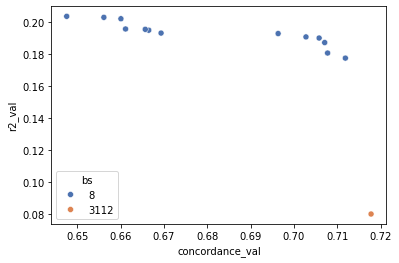

In [61]:
sns.scatterplot(pareto_df, x= "concordance_val", y = "r2_val", hue = 'bs',  palette="deep")

(0.0, 0.21)

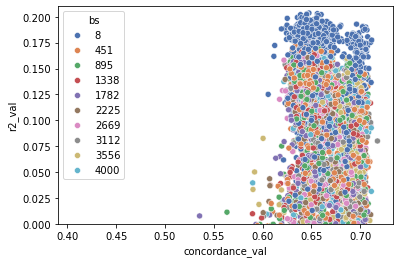

In [60]:
sns.scatterplot(sweep_df, x= "concordance_val", y = "r2_val", hue = 'bs', palette="deep")
plt.ylim([0, 0.21])

In [9]:
best_params_ft = pareto_df.sort_values('r2_val', ascending = False).head(1)
best_params_mort = pareto_df.sort_values('concordance_val', ascending = False).head(1)
middle_ground = pareto_df.sort_values('concordance_val').iloc[9,:]

In [10]:
best_params_ft

,concordance_val,r2_val,beta,bs,lr,wd
5068,0.647582,0.203698,1.0,8,0.000046,0.003594


In [11]:
best_params_mort

,concordance_val,r2_val,beta,bs,lr,wd
0,0.717786,0.080073,0.444444,3112,0.000215,0.001292


In [12]:
middle_ground

concordance_val    0.705807
r2_val             0.190135
beta               0.666667
bs                 8.000000
lr                 0.000010
wd                 0.000167
Name: 105, dtype: float64

In [59]:
sweep_df['bs'].unique()

array([4000, 3556, 3112, 2669, 2225, 1782, 1338,  895,  451,    8])

## Proteins ~ metabolites correlations

In [2]:
train_cmb_met = pd.read_csv('Data/Processed/MultiOmics/proteins_metabolites_train.csv', index_col = 'eid')
train_cmb_mh = pd.read_csv('Data/Processed/MultiOmics/proteins_mh_train.csv', index_col = 'eid')

#allprot = pd.read_csv('Data/Processed/Full/full_train.csv', index_col = 'eid').corr()
corfile = train_cmb_met.corr()

In [3]:
cor_mh = train_cmb_mh.corr()
corr_mh = cor_mh.iloc[-1:,:-1].values

In [4]:
corrmh = pd.DataFrame({'correlation':corr_mh[0,:], 'Correlations between':"Proteins + MH"})
corr_prots = corfile.iloc[:344, :344]
corr_mets = corfile.iloc[344:, 344:]
corr_protmet = corfile.iloc[344:,:]

In [6]:
# Extract the lower triangle (including the diagonal)
lower_triangle = np.tril(corfile)
# lower_traingle_allprot = np.tril(allprot)

# Set the diagonal to NaN
np.fill_diagonal(lower_triangle, np.nan)
# np.fill_diagonal(lower_traingle_allprot, np.nan)

# Replace zeroes with NaN to remove them
lower_triangle[lower_triangle == 0] = np.nan
# lower_traingle_allprot[lower_traingle_allprot == 0] = np.nan

# Convert the numpy array back to a DataFrame if needed
lower_triangle_df = pd.DataFrame(lower_triangle, index=corfile.index, columns=corfile.columns)

#Drop row where we already have all info
lower_triangle_df = lower_triangle_df.dropna(how='all').dropna(axis=1, how='all')
lower_triangle_df

#Select either correlations between proteins, between metabolites, or between metabolites and proteins
protsonly = np.array(lower_triangle_df.iloc[:343, :344])
metsonly = np.array(lower_triangle_df.iloc[343:, 344:])
protmets = np.array(lower_triangle_df.iloc[343:,:344])

#remove NaN
protsonly = pd.DataFrame({'correlation':protsonly[~np.isnan(protsonly)], 'Correlations between':"Proteins"})
metsonly = pd.DataFrame({'correlation':metsonly[~np.isnan(metsonly)], 'Correlations between':"Metabolites"})
protmets = pd.DataFrame({'correlation':protmets[~np.isnan(protmets)], 'Correlations between':"Proteins + metabolites"})
# allprotscor = pd.DataFrame({'correlation':lower_traingle_allprot[~np.isnan(lower_traingle_allprot)], 'Correlations between':"All proteins"})

#make df 
coefsdf = pd.concat([protsonly, metsonly, protmets, corrmh])#, allprotscor])

In [24]:
excluded_prots = ['BMP6','EPHX2','PGLYRP1']

lower_triangle_df[excluded_prots[2]].idxmax()
lower_triangle_df[excluded_prots[1]].max()

0.19003287504632188

In [7]:
coefsdfsub = coefsdf[(coefsdf['Correlations between'] == 'Proteins') | (coefsdf['Correlations between'] == "All proteins")]

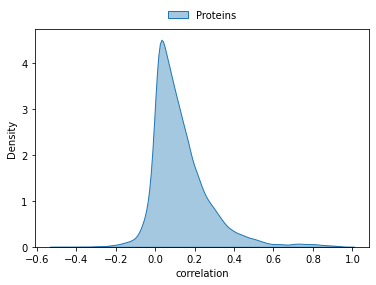

In [10]:
corplt = sns.kdeplot(data=coefsdfsub, x="correlation", hue="Correlations between", fill=True, common_norm=False, alpha=0.4)
sns.move_legend(
    corplt, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.show()
#plt.savefig('cor_multiomics_density.png')

In [ ]:
zien = np.load('output_linear/bootstrap/frailty/metric_frailty_cmb.npy')
# Extract the second element from each array
second_elements = [arr[1] for arr in zien]

# Create a DataFrame with the second elements as a column
df = pd.DataFrame(second_elements, columns=['R2'])
df

corplt = sns.kdeplot(data=df, x="R2", fill=True, common_norm=False, alpha=0.4)
plt.show()

In [ ]:
pd.read_csv('output_linear/bootstrap/frailty/metric_frailty_cmb.npy')


corplt = sns.kdeplot(data=coefsdf, x="correlation", hue="Correlations between", fill=True, common_norm=False, alpha=0.4)
sns.move_legend(
    corplt, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.show()
plt.savefig('cor_multiomics_density.png')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
cor_plot = sns.heatmap(corfile, cmap="viridis", annot=False, ax=ax)
plt.title("correlation proteins and metabolites")

In [ ]:
import scipy.cluster.hierarchy as sch

linkage = sch.linkage(corfile, method='average', metric='euclidean')
dendro = sch.dendrogram(linkage, no_plot=True)
reordered_index = dendro['leaves']
corfile_reordered = corfile.iloc[reordered_index, reordered_index]
fig, ax = plt.subplots(figsize=(10, 10))
cor_plot = sns.heatmap(corfile_reordered, cmap="viridis", annot=False, ax=ax, vmin=-1, vmax=1)
plt.title("Correlations Proteins and Metabolites")
plt.show()


In [ ]:
linkage = sch.linkage(corr_prots, method='average', metric='euclidean')
dendro = sch.dendrogram(linkage, no_plot=True)
reordered_index = dendro['leaves']
corfile_reordered = corr_prots.iloc[reordered_index, reordered_index]
fig, ax = plt.subplots(figsize=(10, 10))
cor_plot = sns.heatmap(corfile_reordered, cmap="viridis", annot=False, ax=ax, vmin=-1, vmax=1)
plt.title("Correlations Proteins Only")
plt.show()


In [ ]:
linkage = sch.linkage(corr_mets, method='average', metric='euclidean')
dendro = sch.dendrogram(linkage, no_plot=True)
reordered_index = dendro['leaves']
corfile_reordered = corr_mets.iloc[reordered_index, reordered_index]
fig, ax = plt.subplots(figsize=(10, 10))
cor_plot = sns.heatmap(corfile_reordered, cmap="viridis", annot=False, ax=ax, vmin=-1, vmax=1)
plt.title("Correlations Metabolites Only")
plt.show()

In [ ]:
linkage = sch.linkage(corr_protmet, method='average', metric='euclidean')
dendro = sch.dendrogram(linkage, no_plot=True)
reordered_index = dendro['leaves']
corfile_reordered = corr_protmet.iloc[reordered_index, reordered_index]
fig, ax = plt.subplots(figsize=(10, 10))
cor_plot = sns.heatmap(corfile_reordered, cmap="viridis", annot=False, ax=ax, vmin=-1, vmax=1)
plt.title("Correlations Proteins With Metabolites")
plt.show()

In [ ]:
corr_protmet.iloc[:,:344].max().hist()

In [ ]:
# cor_mh = cor_mh.iloc[-1,:]
fig, ax = plt.subplots(figsize = (10, 10))
cor_plot = sns.heatmap(corr_mh, cmap="viridis", annot=False, ax=ax)
plt.title("correlation proteins-metabohealth")



In [ ]:
corr_mh.transpose().hist()

## Plate Effects

In [ ]:
train, test, eidstrain, eidstest, cols = get_data({'dset':'cmb', 'target':'frailty'})
protein = cols[140]

proteinind = np.where(cols == protein)[0]

GDF15 = pd.DataFrame(train[0][:,proteinind], columns = ['GDF15'], index = eidstrain)

In [ ]:
platen = pd.read_csv('Data/Olink_UKBB_packageDataFreeze_19Jan2024/67864_olink_0_Instance0_all-info.tab', sep = '\t', index_col = 'eid')
GDF15platen = platen.loc[platen['Assay'] == protein]
GDF15complete = GDF15.merge(GDF15platen, left_index =True, right_index = True)

In [ ]:
sns.boxplot(data = GDF15complete, x='PlateID',y = 'NPX', showfliers = False, width = 1, medianprops={"color": "red", "linewidth": 1}, whis = 0)

In [ ]:
sns.boxplot(data = GDF15complete, x='PlateID',y = 'NPX', showfliers = False, width = 1, medianprops={"color": "red", "linewidth": 1}, whis = 0)

In [ ]:
sns.boxplot(data = GDF15complete, x='Batch',y = 'GDF15')

## Forward Feature selection

In [11]:
ranking_ft_cmb = np.load("output_linear/rsquared/ffs_ranking_cmb.npy")
ranking_ft_cmb_met = np.load("output_linear/rsquared/ffs_ranking_cmb_met.npy")

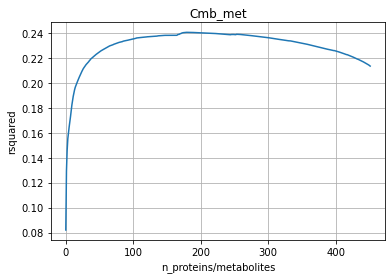

In [13]:
plt.plot(ranking_ft_cmb_met)
plt.title("Cmb_met")
plt.xlabel("n_proteins/metabolites")
plt.ylabel("rsquared")
plt.grid()

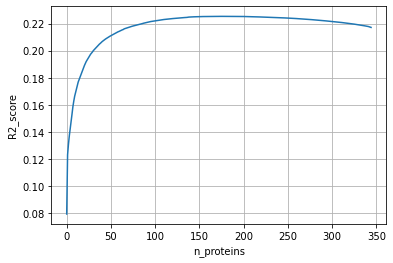

In [12]:
plt.plot(ranking_ft_cmb)
plt.xlabel("n_proteins")
plt.ylabel("R2_score")
plt.grid()

### Mortality stats

In [ ]:
train, val, train_eids, val_eids = get_data({'dset' : "cmb", "target" : "mort"})
meta_val = meta.loc[meta['eid'].isin(val_eids)]
meta_train = meta.loc[meta['eid'].isin(train_eids)]

In [ ]:
train_dead = meta_train.loc[meta_train['died'] == 1]
train_dead.hist('followup')

## TSNEs

In [ ]:
prefix = "Data/Processed/Full"

allprot_train_df = pd.read_csv(prefix + "/full_train.csv")
allprot_val_df = pd.read_csv(prefix + "/full_val.csv")

cmb_train_df = pd.read_csv(prefix + "/full_train_cmb.csv")
cmb_val_df = pd.read_csv(prefix + "/full_val_cmb.csv")

basicinfo = pd.read_csv("Data/basicinfo_instance_0.csv")
FI = pd.read_csv("Data/UKB_FIscores.csv")
FI['eid'] = FI['eid'].astype(int)

In [ ]:
allprots_arr = allprot_train_df.drop(columns = ['eid']).values
allprots_norm = StandardScaler().fit_transform(allprots_arr)

allprots_pca = PCA(n_components = 50).fit_transform(allprots_norm)
allprots_tsne = TSNE(perplexity=50).fit_transform(allprots_pca)

In [ ]:
tsne_df = pd.DataFrame(allprots_tsne, columns = ['tsne_0', 'tsne_1'])

tsne_df['eid'] = allprot_train_df['eid']
full_df = tsne_df.merge(basicinfo, on = 'eid').merge(FI, on = "eid")


In [ ]:
sns.scatterplot(data = full_df, x = 'tsne_0', y = 'tsne_1', hue = 'sex', s = 1)

In [ ]:
sns.scatterplot(data = full_df, x = 'tsne_0', y = 'tsne_1', hue = 'center', s = 1)

In [ ]:
cmap = sns.cubehelix_palette(rot=0.2, as_cmap = True)
norm = plt.Normalize(full_df['age_center.0.0'].min(), full_df['age_center.0.0'].max())
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm )
ax = sns.scatterplot(data = full_df, x= 'tsne_0', y = 'tsne_1', hue = 'age_center.0.0', palette =cmap, legend = False, s= 1)
ax.figure.colorbar(sm, ax = ax, label = "age")

In [ ]:
cmap = sns.cubehelix_palette(rot=0.2, as_cmap = True)
norm = plt.Normalize(full_df['FI_0'].min(), full_df['FI_0'].max())
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm )
ax = sns.scatterplot(data = full_df, x= 'tsne_0', y = 'tsne_1', hue = 'FI_0', palette =cmap, legend = False, s= 1)
ax.figure.colorbar(sm, ax = ax, label = "frailty")